In [79]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import pandas as pd

%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


In [80]:
data_path = "dataset/"
emotions = os.listdir(data_path)

# Check for '.DS_Store' and delete it
if '.DS_Store' in emotions:
    os.remove(os.path.join(data_path, '.DS_Store'))
    emotions.remove('.DS_Store')

print(emotions)

['happy', 'unhappy', 'tense', 'neutral']


dataset/happy
dataset/unhappy
dataset/tense
dataset/neutral


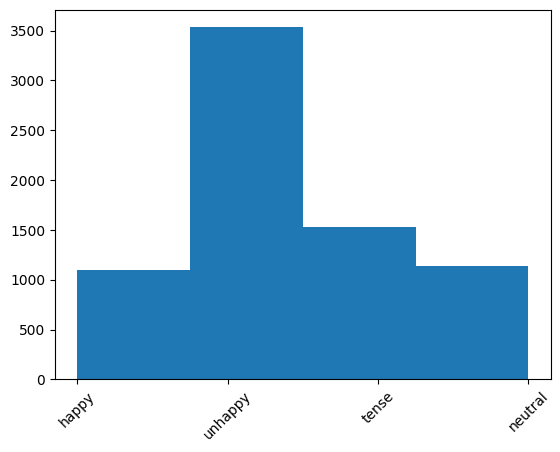

In [81]:
img_size = 48 #By default, the images in FER2013 dataset is in 48x48

data = []
labels = []

# Looping through subfolders in the data path
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    print(emotion_folder)
    if not os.path.isdir(emotion_folder):
        continue
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(emotions.index(emotion))

# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Plot the distribution of the labels, bar graph
plt.hist(labels, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.show()

Total data in train set: 5102
Total data in validation set: 2187


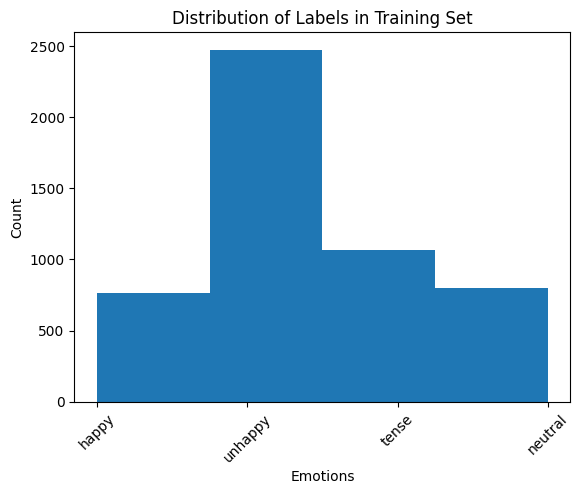

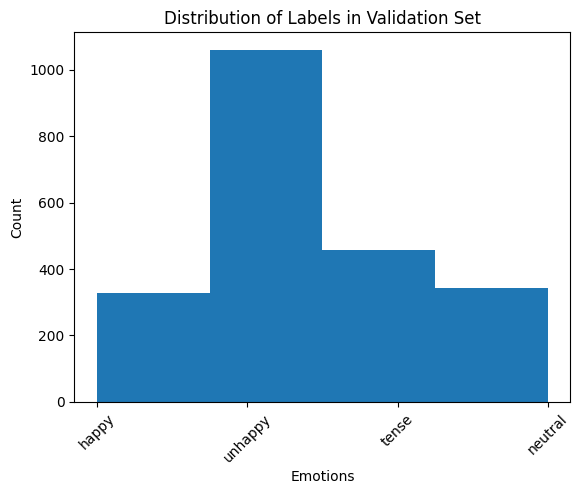

In [82]:
data_path = "dataset/"
emotions = os.listdir(data_path)

data = []
labels = []
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    if not os.path.isdir(emotion_folder):
        continue
    images = os.listdir(emotion_folder)
    for img in images:
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(emotions.index(emotion))

# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Normalize the data
data = data / 255.0

# Reshape the data to add a channel dimension
data = data.reshape(-1, img_size, img_size, 1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

print("Total data in train set:", len(X_train))
print("Total data in validation set:", len(X_val))
# Plot the distribution of labels in the training set
plt.hist(y_train, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.title("Distribution of Labels in Training Set")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()

# Plot the distribution of labels in the validation set
plt.hist(y_val, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.title("Distribution of Labels in Validation Set")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()


Number of data in happy folder: 3266
Number of data in unhappy folder: 3534
Number of data in tense folder: 3341
Number of data in neutral folder: 3282
Total number of data in train folder: 13423


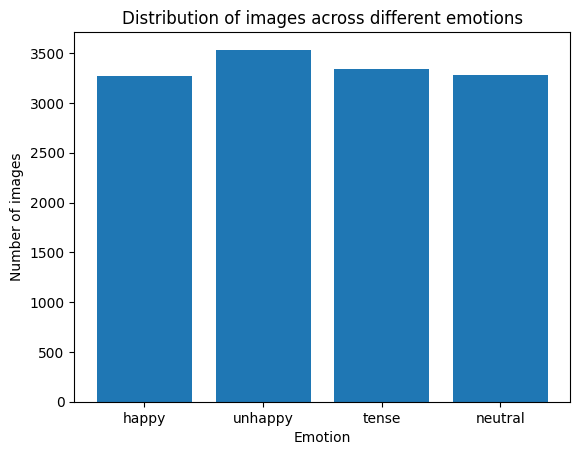

In [83]:
import random
import shutil
import matplotlib.pyplot as plt

train_dir = "train/"

# Delete the train_dir if it exists
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

# Create a new train_dir
os.makedirs(train_dir, exist_ok=True)
emotions = [e for e in os.listdir(data_path) if e != 'test']

# Calculate the maximum number of images in any emotion folder
max_images = max(len(os.listdir(os.path.join(data_path, e))) for e in emotions)

# Initialize an empty dictionary to store the count of images for each emotion
emotion_counts = {}

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    if not os.path.isdir(emotion_folder):
        continue
    data = []
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            data.append(img)
    if len(data) == 0:
        continue
    data = np.array(data)
    labels = np.full((len(data),), emotions.index(emotion))
    train_emotion_folder = os.path.join(train_dir, emotion)
    os.makedirs(train_emotion_folder, exist_ok=True)
    for i in range(len(data)):
        img_path = os.path.join(train_emotion_folder, f"{emotion}_{i}.jpg")
        cv2.imwrite(img_path, data[i])

    # If this folder has less images than the maximum, randomly duplicate some
    if len(data) < max_images:
        to_duplicate = max_images - len(data)
        for _ in range(to_duplicate):
            img_to_duplicate = random.choice(data)
            img_to_duplicate = img_to_duplicate.reshape((1,) + img_to_duplicate.shape + (1,))  # Add an extra dimension for the grayscale channel
            for batch in datagen.flow(img_to_duplicate, batch_size=1, save_to_dir=train_emotion_folder, save_prefix=emotion, save_format='jpg'):
                break  # We only want to generate one augmented image, so break the loop

    # Count the number of data in each folder
    train_data_count = len(os.listdir(train_emotion_folder))
    print(f"Number of data in {emotion} folder: {train_data_count}")

    # Store the count in the dictionary
    emotion_counts[emotion] = train_data_count

# Count the total number of data in train folder
total_train_data_count = sum([len(files) for r, d, files in os.walk(train_dir)])
print(f"Total number of data in train folder: {total_train_data_count}")

# Plot a bar graph of the image counts
plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.xlabel('Emotion')
plt.ylabel('Number of images')
plt.title('Distribution of images across different emotions')
plt.show()

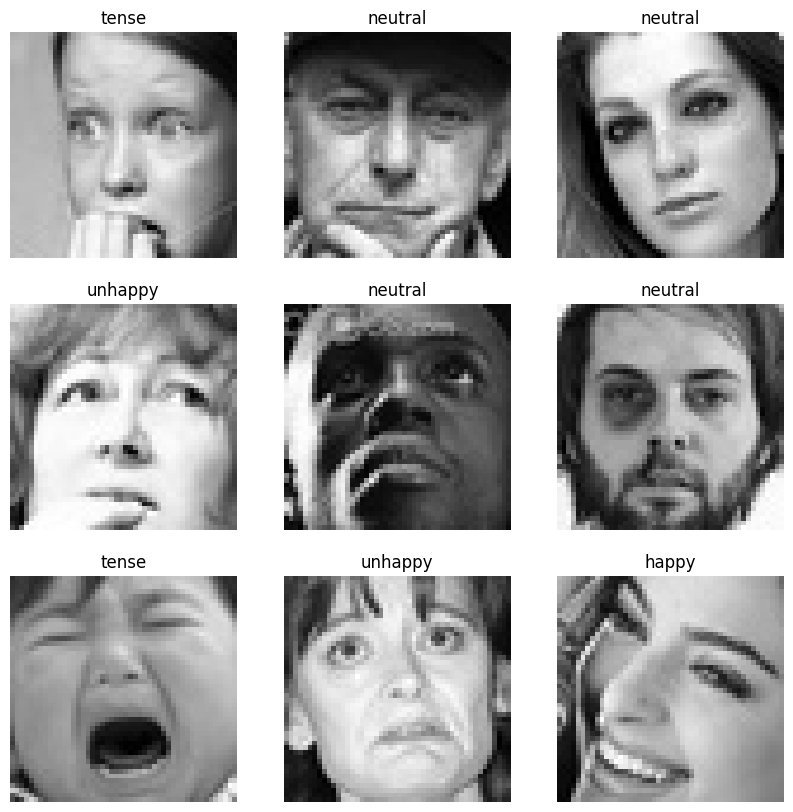

In [84]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(img_size, img_size), cmap='gray')
    plt.title(emotions[y_train[i]])
    plt.axis('off')
plt.show()

In [91]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = 48

def preprocess_image(img):
    return img

# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   validation_split=0.3,
                                   preprocessing_function=preprocess_image)

train_gen = train_datagen.flow_from_directory(directory="train/",
                                              target_size=(img_size, img_size),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              subset='training')

test_gen = train_datagen.flow_from_directory(directory="train/",
                                             target_size=(img_size, img_size),
                                             color_mode='rgb',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             subset='validation')

Found 9398 images belonging to 4 classes.
Found 4025 images belonging to 4 classes.


In [92]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, LeakyReLU


# Load the VGG16 model but exclude the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(48, 48, 3)))

# Make sure the layers of the VGG16 model are not trainable
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()

# Add the base model for feature extraction
model.add(base_model)

# Flatten the output of the base model
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))

# Add the output layer
model.add(Dense(4, activation='softmax'))

# Use a learning rate schedule
opt = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 
                                                                        tf.keras.metrics.Precision(), 
                                                                        tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_40 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                     

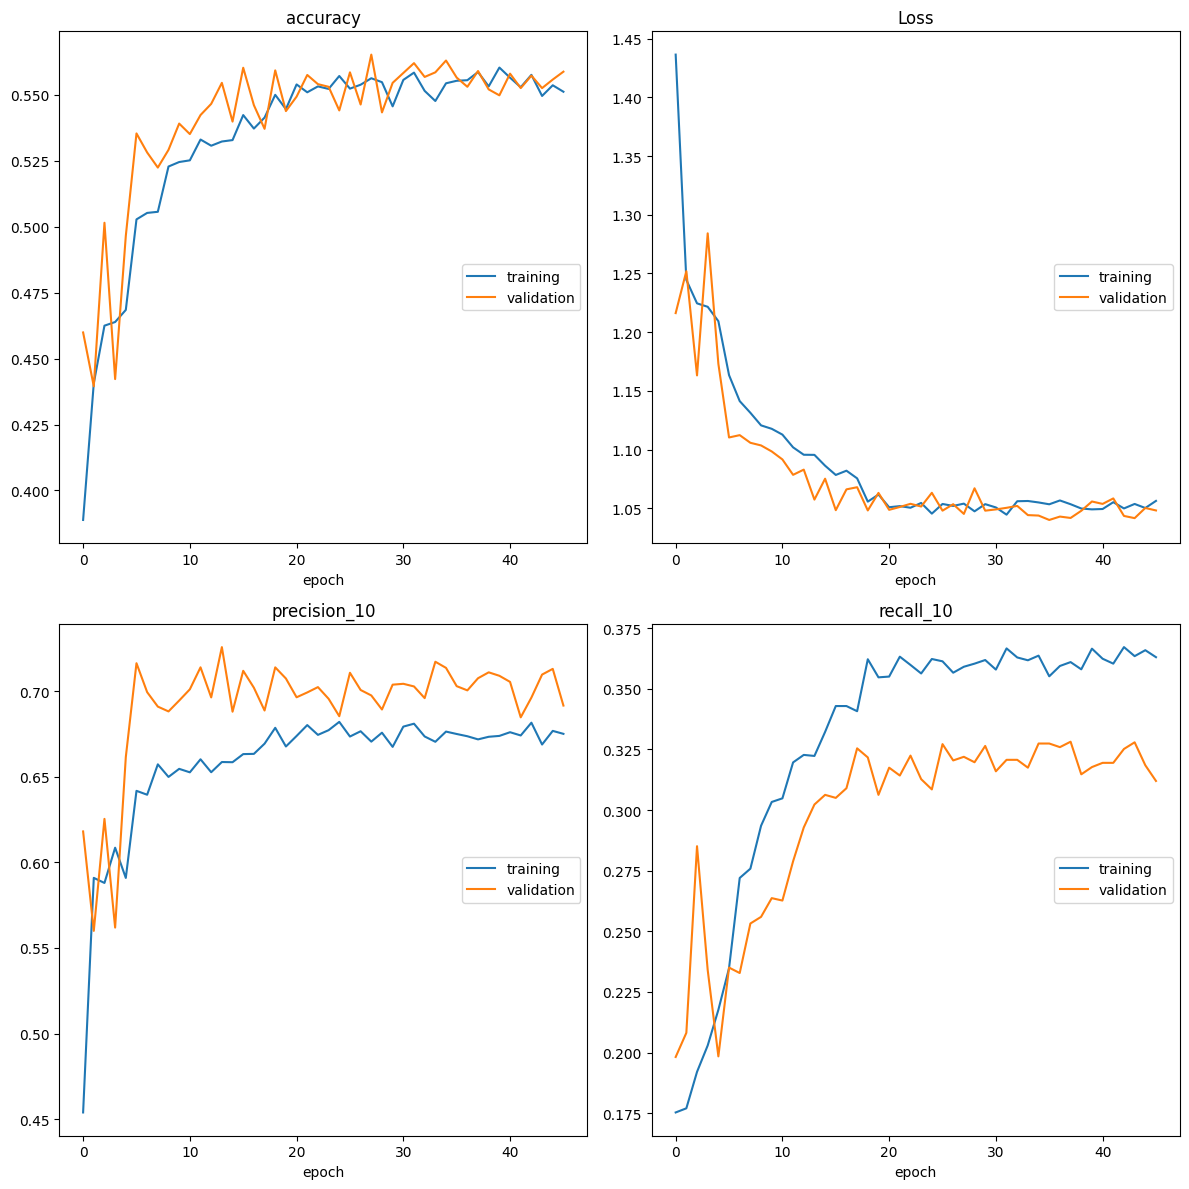

accuracy
	training         	 (min:    0.389, max:    0.560, cur:    0.551)
	validation       	 (min:    0.439, max:    0.565, cur:    0.559)
Loss
	training         	 (min:    1.045, max:    1.436, cur:    1.056)
	validation       	 (min:    1.040, max:    1.284, cur:    1.048)
precision_10
	training         	 (min:    0.454, max:    0.682, cur:    0.675)
	validation       	 (min:    0.560, max:    0.726, cur:    0.692)
recall_10
	training         	 (min:    0.175, max:    0.367, cur:    0.363)
	validation       	 (min:    0.198, max:    0.328, cur:    0.312)

Epoch 46: saving model to model_weights.h5
587/587 [==============================] - 15s 25ms/step - loss: 1.0564 - accuracy: 0.5512 - precision_10: 0.6750 - recall_10: 0.3630 - val_loss: 1.0482 - val_accuracy: 0.5588 - val_precision_10: 0.6915 - val_recall_10: 0.3120 - lr: 1.0000e-05


In [93]:
from keras.callbacks import CSVLogger, TensorBoard
from keras.callbacks import EarlyStopping

steps_per_epoch = train_gen.n//batch_size
test_steps = test_gen.n//batch_size
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

epochs = 100

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')
csv_logger = CSVLogger('training.log')

tensorboard = TensorBoard(log_dir='./result', histogram_freq=0, write_graph=True, write_images=False)

# Use this callback in your model.fit call
callbacks= [PlotLossesKeras(), checkpoint, reduce_lr, csv_logger, tensorboard]

history = model.fit(x = train_gen,
                   steps_per_epoch = steps_per_epoch,
                   epochs=epochs,
                   validation_data=test_gen,
                   validation_steps = test_steps,
                   callbacks=[early_stopping]+callbacks)

In [58]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)